

### Contexte

Le but de ce projet est de reproduire un cercle de culture ("Crop circle" : Un vaste motif ou ensemble de motifs géométriques réalisé dans un champ de céréales). Un script Python a été développé en utilisant une approche orientée objet et en faisant appel aux bibliothèques NumPy et Matplotlib. Dans un premier temps, le choix du motif à reproduire ainsi que les objectifs du script ont été définis. Ensuite, les classes de base ("Interval", "Renderable", "Transformation", etc.) ont été implémentées, suivies des classes de fonction ("CoupleSplineFunction", "PolynomialFunction") et des classes de transformations ("Rotation" et "Translation"). Enfin, la classe "Curve" a été conçue pour gérer le rendu des objets "Renderable" avec Matplotlib, ainsi que la logique pour assembler toutes les formes et les dessiner.

### Objectif

Le but est de recréer le motif en implémentant l'interpolation de Lagrange, les splines cubiques et les courbes de Bézier en Python à l'aide des bibliothèques NumPy et Matplotlib. Ce projet met en avant l'utilisation d'algorithmes mathématiques pour la création et la manipulation précise de formes géométriques complexes, tout en exploitant les capacités de visualisation graphique.


In [2]:
import warnings

from typing import Any

import matplotlib.pyplot as plt
import numpy as np

from numpy.linalg import solve
from scipy.special import binom

In [3]:
class Interval:
    start: float = None # Début de l'intervalle
    end: float = None # Fin de l'intervalle
    """Taille du pas pour diviser l'intervalle à partir de la limite inférieure"""
    step: float = None
    """Nombre de parties pour diviser l'intervalle"""
    slice: float = None
    
    def __init__(self, start=0, end=50, slice=None, step=None) -> None:
        assert bool(slice) ^ bool(step), 'Soit slice soit step doit être défini'
        assert start is not end, 'start et end doivent être différents'
        self.start = start if start < end else end
        self.end = end if end > start else start
        self.step = step
        self.slice = slice

    @property
    def value(self):
        if self.slice:
            return np.linspace(self.start, self.end, self.slice)
        elif self.step:
            if self.step > self.end - self.start:
                warnings.warn('le pas fourni est plus grand que la taille de l\'intervalle')
            if (self.end - self.start) % self.step != 0:
                warnings.warn('la limite inférieure de l\'intervalle est tronquée')
            return np.arange(self.start, self.end, self.step)
        else:
            return np.array((self.start, self.end))

In [4]:
# Tester l'intervalle
interval = Interval(start=0, end=50, step=10)
print(interval.value)

[ 0 10 20 30 40]


## Classe Renderable
Représente tout object pouvant etre affiché et de ce fait possedant une liste de coordonnées de points

In [5]:
class Renderable:
    def __init__(self, style: list = None) -> None:
        self.style = style

    @property
    def vx(self):
        pass

    @property
    def vy(self):
        pass

## Création de la classe transformation Renderable
Représente les transformations géometriques applicables aux fonctions

In [6]:
class Tranformation(Renderable):
    def __init__(self, function: Renderable, style: list = None):
        self.function = function  # Initialiser l'attribut function avec l'objet Renderable passé en paramètre
        super().__init__(style)  # Appeler le constructeur de la classe parente Renderable

## Création de la classe rotation Renderable

In [7]:
class Rotation(Tranformation):

    def __init__(self, function: Renderable, angle: float, style: list = None):
        self.angle = angle # Initialiser l'attribut angle avec la valeur passée en paramètre
        self.function = function # Initialiser l'attribut function avec l'objet Renderable passé en paramètre
        super().__init__(function=function, style=style) # Appeler le constructeur de la classe parente Tranformation

    @property
    def vx(self):
        # Calculer les nouvelles coordonnées x après rotation
        return [x * np.cos(self.angle) - y * np.sin(self.angle) for x, y in zip(self.function.vx, self.function.vy)]
    
    @property
    def vy(self):
        # Calculer les nouvelles coordonnées y après rotation
        return [x * np.sin(self.angle) + y * np.cos(self.angle) for x, y in zip(self.function.vx, self.function.vy)]

## Création de la classe translation Renderable

In [8]:
class Translation(Renderable):

    def __init__(self, function: Renderable, vector: tuple[float, float], style: list = None):
        self.vector = vector # Initialiser l'attribut vector avec le tuple passé en paramètre
        self.function = function # Initialiser l'attribut function avec l'objet Renderable passé en paramètre
        super().__init__(style) # Appeler le constructeur de la classe parente Renderable

    @property
    def vx(self):
        # Ajouter la composante x du vecteur de translation à chaque coordonnée x
        return [x + self.vector[0] for x in self.function.vx]

    @property
    def vy(self):
        # Ajouter la composante y du vecteur de translation à chaque coordonnée y
        return [y + self.vector[1] for y in self.function.vy]

## Création de la classe fonction Renderable
Représente la classe de base des fonctions
Elle est chargée de récupérer les coordonnées des points par lesquels doit passer la courbe, de générer la matrice de résolution des equations et de générer la fonction

In [9]:
class Function(Renderable):
    f: callable = None

    def __init__(self, init_vx: list[float], init_vy: list[float], interval: Interval = None, style: list = None):
        self.init_vx = init_vx
        self.init_vy = init_vy
        # Initialiser l'attribut interval avec l'objet Interval passé en paramètre, ou créer un nouvel objet Interval si aucun n'est fourni
        self.interval = interval if interval else Interval(np.min(init_vx), np.max(init_vx), slice=200)
        self.f = self.build_f() # Construire la fonction f
        super().__init__(style) 

    def gen_A(self):
        pass # Cette méthode est destinée à générer une matrice A (à implémenter)

    def build_f(self):
        pass # Cette méthode est destinée à construire la fonction f (à implémenter)

    def __call__(self, x) -> Any:
        # Permet d'appeler l'objet comme une fonction et retourne le résultat de l'appel de la fonction f avec x en argument.
        return self.f(x)
    
    @property
    def vx(self):
        # Retourne les valeurs x de l'intervalle
        return self.interval.value

    @property
    def vy(self):
        # Retourne les valeurs y calculées en appelant la fonction f pour chaque valeur x
        return [self.f(x) for x in self.vx]

## Génération de Splines cubiques avec  2 points

In [10]:
class CoupleSplineFunction(Function):
    def __init__(self, init_vx: tuple[float, float], init_vy: tuple[float, float], valpha: tuple[float, float] = (10, 10), interval: Interval = None, style: list = None):
        self.valpha = valpha
        super().__init__(init_vx=init_vx, init_vy=init_vy, interval=interval, style=style)

    def gen_A(self):
        X = self.init_vx
        # Générer et retourner une matrice A basée sur les valeurs initiales de x
        return np.array([[1, X[0], X[0]**2, X[0]**3],
                         [1, X[1], X[1]**2, X[1]**3],
                         [0, 1, 2*X[0], 3*X[0]**2],
                         [0, 1, 2*X[1], 3*X[1]**2]])

    def build_f(self):
        # Résoudre le système d'équations linéaires pour obtenir les coefficients de la fonction spline
        coef = solve(self.gen_A(), self.init_vy + self.valpha)
        # Construire et retourner la fonction spline en utilisant les coefficients obtenus
        return lambda x: coef[0] + coef[1]*x + coef[2]*x**2 + coef[3]*x**3

## Génération d'Interpolation de Lagrange

In [11]:
class PolynomialFunction(Function):

    def __init__(self, init_vx, init_vy, interval=None, style: list = None):
        super().__init__(init_vx=init_vx, init_vy=init_vy, interval=interval, style=style) # Appeler le constructeur de la classe parente Function

    def gen_A(self):
        vx = self.init_vx # Récupérer les valeurs initiales de x
        def reckon_row(x, size):
            row = []
            for i in range(1, size+1):
                row.append(x**i) # Ajouter x à la puissance i à la ligne
            return row
        base_degree = len(vx) # Calculer le degré de base en fonction de la longueur de vx
        # Générer et retourner la matrice A en calculant une ligne pour chaque valeur de x
        return [reckon_row(x, base_degree) for x in vx]


    def build_f(self):
        # Résoudre le système d'équations linéaires pour obtenir les coefficients du polynôme
        coef = solve(np.array(self.gen_A()), np.array(self.init_vy))
        def reckon(x, degree = 0., a = 0.):
            return a*x**degree # Calculer a*x à la puissance degree
        def f(x):
            # Calculer la somme des termes du polynôme pour la valeur de x donnée
            return np.sum([reckon(x, degree=index + 1, a=a) for index, a in enumerate(coef)])
        return f # Retourner la fonction polynomiale construite

## Génération de Courbes de Bezier

In [12]:
class BezierFunction(Function):

    def build_f(self):
        Nb = len(self.init_vx)
        def Bezier(t):
            C = np.array([0,0])
            for i in range(0,Nb):
                C = C + binom(Nb-1, i)*t**i*(1 - t)**(Nb-1 - i) * \
                    np.array([self.init_vx[i], self.init_vy[i]])
            return C
        return Bezier
    
    @property
    def vgamma(self):
        return np.array([self(t) for t in self.vt]).transpose()

    @property
    def vt(self):
        return np.linspace(0,1,100)

    @property
    def vx(self):
        return self.vgamma[0]
    
    @property
    def vy(self):
        return self.vgamma[1]


## Génération tracer une courbe paramétrée

In [13]:
class VariableFunction(Renderable):

    def __init__(self, x_builder: callable, y_builder: callable, interval: Interval = None, style: list = None) -> None:
        self.x_builder = x_builder
        self.y_builder = y_builder
        self.interval = interval
        super().__init__(style) # Appeler le constructeur de la classe parente Renderable

    def __call__(self, x) -> Any:
        # Permet d'appeler l'objet comme une fonction. Retourne le résultat de l'appel de la fonction y_builder avec x en argument.
        return self.y_builder(x)

    @property
    def vx(self):
        # Retourne les valeurs x calculées en appelant la fonction x_builder pour chaque valeur t dans l'intervalle
        return [self.x_builder(t) for t in self.interval.value]
    
    @property
    def vy(self):
        # Retourne les valeurs y calculées en appelant la fonction y_builder pour chaque valeur t dans l'intervalle
        return [self.y_builder(t) for t in self.interval.value]

## Cas particuliers des courbes paramétrées

### Courbe Spirale

C'est un cas particulier des courbes paramétrées qui, dans notre cas, servira à dessiner des cercles lorsque le rayon est fixe et des spirales lorsque le rayon est variable.

In [14]:
class SpinFunction(VariableFunction):

    def __init__(self, r_builder: callable, interval: Interval = None, style: list = None) -> None:
        self.r_builder = r_builder
        # Définir la fonction x_builder comme le produit de r_builder(t) et du cosinus de t
        x_builder = lambda t: r_builder(t)*np.cos(t)
        # Définir la fonction y_builder comme le produit de r_builder(t) et du sinus de t
        y_builder = lambda t: r_builder(t)*np.sin(t)
        # Appeler le constructeur de la classe parente VariableFunction avec x_builder, y_builder et l'intervalle donné
        # Si aucun intervalle n'est fourni, utiliser un nouvel objet Interval allant de 0 à 20*pi avec 500 points
        super().__init__(
            x_builder=x_builder,
            y_builder=y_builder,
            interval=interval if interval else Interval(0, 20*np.pi, slice=500),
            style=style,
        )

## Class Courbe
Représente le rendu final
Elle permet d'afficher toutes les fonctions (Renderable) qui lui sont passés en paramètre

In [15]:
class Curve:

    def __init__(self, functions: list[Renderable] = [], styles: list[list]=[['r', '-', '', ''], ['g', ':', '', ''], ['b', '-', '', ''], ['b', ':', '', '']]) -> None:
        self.functions = functions # Initialiser l'attribut functions avec la liste d'objets Renderable passée en paramètre
        self.styles = styles # Initialiser l'attribut styles avec la liste de styles passée en paramètre


    def render(self):
        len_styles = len(self.styles) # Calculer la longueur de la liste de styles

        for index, f in enumerate(self.functions): # Pour chaque fonction dans la liste
            X = f.vx # Récupérer les valeurs x
            Y = f.vy # Récupérer les valeurs y
            style = f.style if f.style else self.styles[index % len_styles] # Récupérer le style correspondant à la fonction
            plt.plot(X, Y, color=style[0], linestyle=style[1], marker=style[2]) # Tracer la fonction
            if style[3]:
                plt.fill_between(np.min(X), np.min(Y), np.max(Y), interpolate=True)
        plt.axis('equal') # Régler les axes pour qu'ils aient la même échelle

## Utilisation des Splines cubiques à 2 points
Pour la création des motifs à l'intérieur du crop circle

In [16]:
# Création d'un arc de cercle partant du centre
arc0 = CoupleSplineFunction(
    init_vx=(0, 15),
    init_vy=(0, 0),
    valpha=(1, -1),
)
# Création du second arc de cercle se terminant avec le dernier point de arc0
arc1 = CoupleSplineFunction(
    init_vx=(0, 26.5),
    init_vy=(0, 0),
    valpha=(1, -1),
)
# Création du troisième arc de cercle partant du premiere point de arc1 pour finir sur un côté de l'heptagone
arc2 = CoupleSplineFunction(
    init_vx=(0, 52),
    init_vy=(0, 0),
    valpha=(1.5, -1.5),
)

# Récupérer de arc0, arc1 et arc2 pour former le bras allant du centre à un côté de l'heptagone
# La translation et rotation servent à ce que chaque arc se rejoigne par des points précis et forment un bras
wave_shape = [
    Translation(Rotation(arc0, angle=-np.pi/6),vector=(0, 5)),
    Translation(Rotation(arc1, angle=-np.pi/3),vector=(0, 20)),
    Translation(Rotation(arc2, angle=-np.pi/3),vector=(0, 20)),
]

# Applique une translation sur chaque composante (fonction) contenue dans une forme (liste de fonctions)
def translate_shape(shape, vector):
    return [ Translation(func, vector=vector) for func in shape]

# Applique une rotation sur chaque composante (fonction) contenue dans une forme (liste de fonctions)
def rotate_shape(shape, angle):
    return [ Rotation(func, angle=angle) for func in shape]

# Duplique les bras et appliques les rotations
waves = []

# Pour une intervalle fourni, 0 à 2*pi avec 8 points
# permet d'afficher les 7 bras avec un decalage de 45°
for angle in np.linspace(0, 2*np.pi, 8):
    waves += rotate_shape(wave_shape, angle)

In [17]:
# Création des décorations de cercle au sommet de l'heptagone
# Cercle au centre de la décoration de rayon 1
main_circle = SpinFunction(
    r_builder=lambda r: 2,
    interval=Interval(start=0, end=2*np.pi, slice=100),
)

# Cercles de décoration de rayon 0.75 au dessus du main_circle
circle0 = Translation(
    SpinFunction(
    r_builder=lambda r: 1.5,
    interval=Interval(start=0, end=2*np.pi, slice=100),
),
vector=(0, 6),
)

# Cercles de décoration de rayon 0.5 au dessus du circle0
circle1 = Translation(
    SpinFunction(
    r_builder=lambda r: 1,
    interval=Interval(start=0, end=2*np.pi, slice=100),
),
    vector=(0, 10),
)

# Régroupement des cercles de décoration circle0 et circle1
arm_shape = [circle0, circle1]

# Duplication des cercles de décoration et application des rotations
arms = []
# Pour une intervalle fourni, 0 à 2*pi avec 4 points
# Permet d'afficher les 3 bras avec un decalage de 90°
for angle in np.linspace(0, 2*np.pi, 4):
    arms += rotate_shape(arm_shape, angle)

# Régroupement des cercles de décoration main_circle et arms du centre vers un sommet de l'heptagone
decoration_circle_shape = [ Translation(shape, (0, 46)) for shape in ([main_circle]+ arms)]

# Duplication des cercles de décoration et application des rotations
decoration_circles = []

# Pour une intervalle fourni, 0 à 2*pi avec 8 points
# Permet d'afficher les 7 bras avec un decalage de 45°
for angle in np.linspace(0, 2*np.pi, 8):
    decoration_circles += rotate_shape(decoration_circle_shape, angle)

In [18]:
# Création de la forme finale
# Régroupement des bras et des cercles de décoration
forms = [
    # Grand cercle intérieur
    SpinFunction(
        r_builder=lambda r: 36,
        interval=Interval(start=0, end=2*np.pi, slice=500),
    ),
    # Petit heptagone intérieur
    Rotation(
        SpinFunction(
            r_builder=lambda r: 5,
            interval=Interval(start=0, end=2*np.pi, slice=8),
        ),
        angle=np.pi / 2,
    ),
    # Grand heptagone extérieur
    Rotation(
        SpinFunction(
            r_builder=lambda r: 40,
            interval=Interval(start=0, end=2*np.pi, slice=8),
        ),
        angle=np.pi / 2,
    ),
]

In [19]:
base_tentacle = BezierFunction(
    init_vx=np.array([0, -4, 9, -28, 50, -28, 0, 5, -27, 50, -27, 13, -1, 3]) * 4,
    init_vy=np.array([0, 3, 4, 5, 8, 11, 20, 20, 11, 8, 5, 4, 3, 0]) * 4,
)

tentacle = Translation(Rotation(base_tentacle, -np.pi / 8), (12.5, 34))

tentacles = []
# Pour une intervalle fourni, 0 à 2*pi avec 8 points
# Permet d'afficher les 7 tentacules avec un decalage de 45°
for angle in np.linspace(0, 2*np.pi, 8):
    tentacles += rotate_shape([tentacle], angle)

## Génération de test
C'est ici que chaqu'une de nos classes ont été testé.

Cependant, le test de l'interpolation de lagrange à été effectué mais n'a pas été concluant.
Il n'aura finalement pas été utilisé pour notre forme final et à été remplacer par des splines à 2 points.

In [20]:
# Test de chaque class fonction créée pour vérifier si elle fonctionne correctement
test_functions = [
    # PolynomialFunction(init_vx = [2, 8, 10, 13, 17, 18, 19, 21], init_vy = [2, 5, -2, 8, 4, 0, 1, 5]),

    # PolynomialFunction(init_vx = [2, 8, 17, 18, 19, 21], init_vy = [-2, 8, 4, 0, 1, 5]),

    # PolynomialFunction(init_vx = [2, 8, 17],init_vy = [-2, 8, 4]),

    # SpinFunction(r_builder=lambda r: r+1),

    # Translation(SpinFunction(r_builder=lambda r: 1), (5, 5)),
    # SpinFunction(r_builder=lambda r: 1),
    # SpinFunction(r_builder=lambda r: 1, interval=Interval(start=0, end=2*np.pi, slice=8)),
    # SpinFunction(r_builder=lambda r: 1, interval=Interval(start=0, end=2*np.pi, slice=8)).apply_rotation(-np.pi / 2),
    # Rotation(CoupleSplineFunction(init_vx=(0, 5), init_vy=(0, 0), valpha=(1, -1)), -np.pi / 3),
    # BezierFunction(init_vx = [0, 6, -6, 2, -2, 9, 6, 3], init_vy = [0, 4, 12, 25, 14, 6, 4, 0]),
]

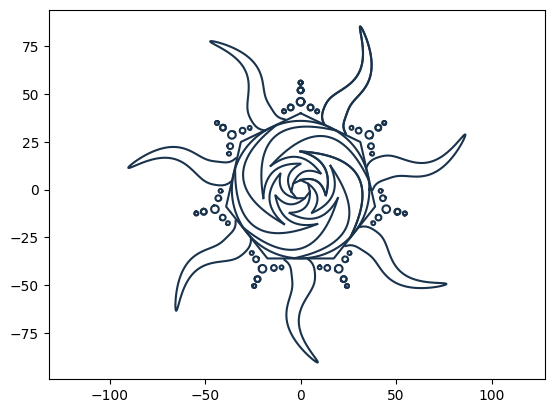

In [21]:
# Fonctions qui ajout des formes, ondes et cercles de décoration
functions = test_functions + forms + waves + decoration_circles + tentacles

# Création de la courbe avec les fonctions et styles définis
curve = Curve(functions=functions, styles=[((0.1, 0.2, 0.3), '-', '', '')],)

# Afficher le resultat finale de toutes les fonctions
curve.render()